In [39]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"]=20,20
%matplotlib inline

def func(x, *params):  # x0 pk width
    y = np.zeros_like(x)
    for i in range(0, len(params)-1, 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y+params[-1] 

hdulist = pyfits.open("test_files/arc.fits")

arcimg = np.rot90(hdulist[0].data, -1)
arcimg = arcimg * 1.0 / np.max(arcimg, axis=1)[:, None]

spatialaxis=np.arange(0,arcimg.shape[0])
waveaxis=np.arange(0,arcimg.shape[1])

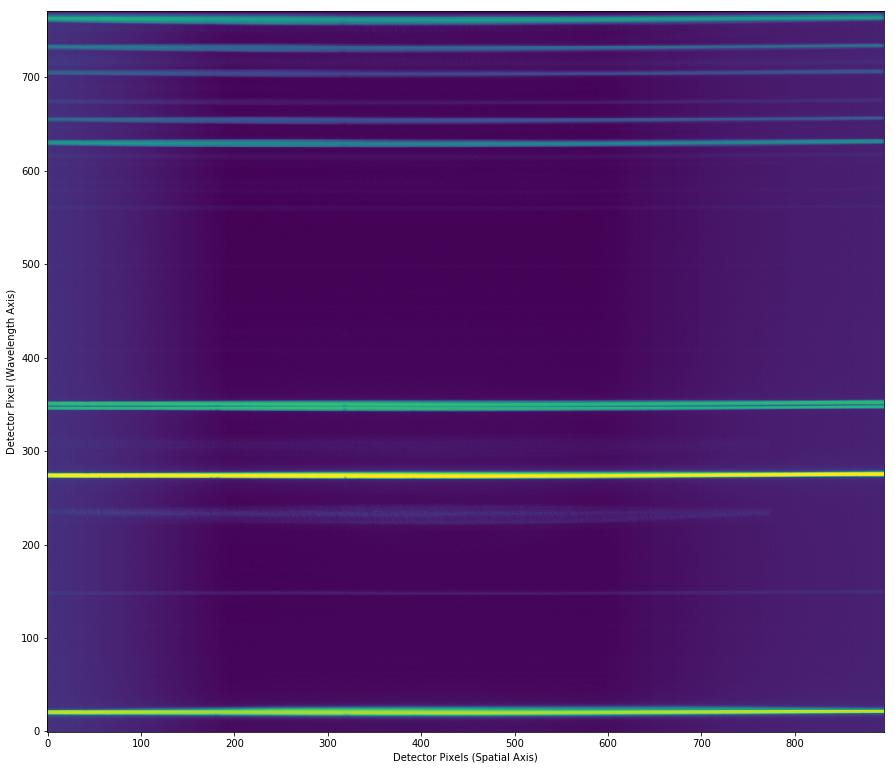

In [38]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(np.log10(arcimg.transpose()),origin='lower')
plt.ylabel('Detector Pixel (Wavelength Axis)')
plt.xlabel('Detector Pixels (Spatial Axis)')
plt.show()

In [5]:
spatial_col_skip=5
fits = np.zeros((len(range(1, arcimg.shape[0], spatial_col_skip))+1, 28))

spec = arcimg[0, :]
peaks, properties = find_peaks(spec, height=0.01, width=1.5, prominence=0.01)


y0 = np.zeros((peaks.size * 3))
y0[0::3] = peaks
y0[1::3] = properties["peak_heights"]
y0[2::3] = properties["widths"] * 0.5
y0 = np.append(y0, 0.02)

fits[0,:], pcov = curve_fit(func, waveaxis, spec, p0=y0)
i=0
for col in tqdm(range(1, arcimg.shape[0], spatial_col_skip)):
    i+=1
    spec = arcimg[col, :]
    y0 = fits[i-1,:]
    fits[i,:], pcov = curve_fit(func, waveaxis, spec, p0=y0)

100%|██████████| 179/179 [00:31<00:00,  5.71it/s]


100%|██████████| 9/9 [00:00<00:00, 365.07it/s]


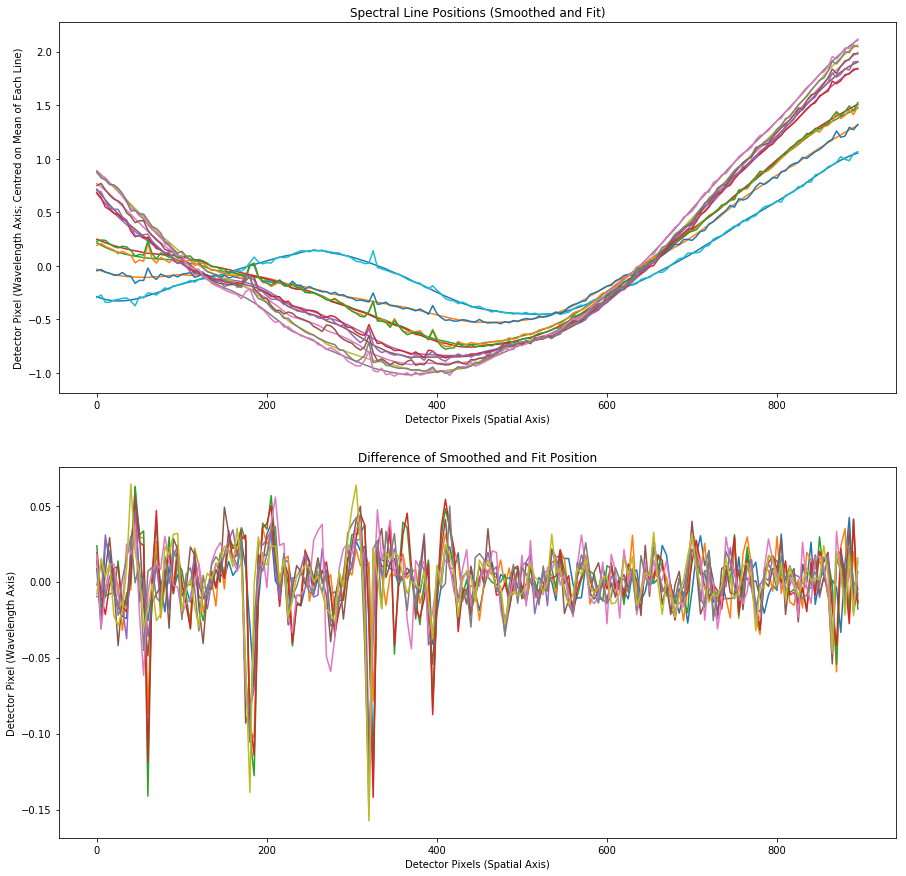

In [37]:
plt.figure(figsize=(15,15))

pos=fits[:,range(0,fits.shape[1]-1,3)]
peakheight=fits[:,range(0,fits.shape[1]-1,3)]
width=fits[:,range(2,fits.shape[1]-1,3)]

smooth_pos = np.zeros_like(pos)

for row in tqdm(range(0, pos.shape[1])):
    smooth_pos[:,row] = savgol_filter(pos[:,row], 21, 3)
    
plt.subplot(211)
plt.plot(spatialaxis[range(0, arcimg.shape[0], spatial_col_skip)], smooth_pos - np.mean(pos,axis=0)) 
plt.plot(spatialaxis[range(0, arcimg.shape[0], spatial_col_skip)], pos - np.mean(pos,axis=0))
plt.title('Spectral Line Positions (Smoothed and Fit)')
plt.ylabel('Detector Pixel (Wavelength Axis; Centred on Mean of Each Line)')
plt.xlabel('Detector Pixels (Spatial Axis)')

plt.subplot(212)
plt.plot(spatialaxis[range(0, arcimg.shape[0], spatial_col_skip)], smooth_pos - pos) #-np.mean(fits[:,range(0,fits.shape[1]-1,3)],axis=0) #- np.mean(pos,axis=0)
plt.title('Difference of Smoothed and Fit Position')
plt.ylabel('Detector Pixel (Wavelength Axis)')
plt.xlabel('Detector Pixels (Spatial Axis)')
plt.show()

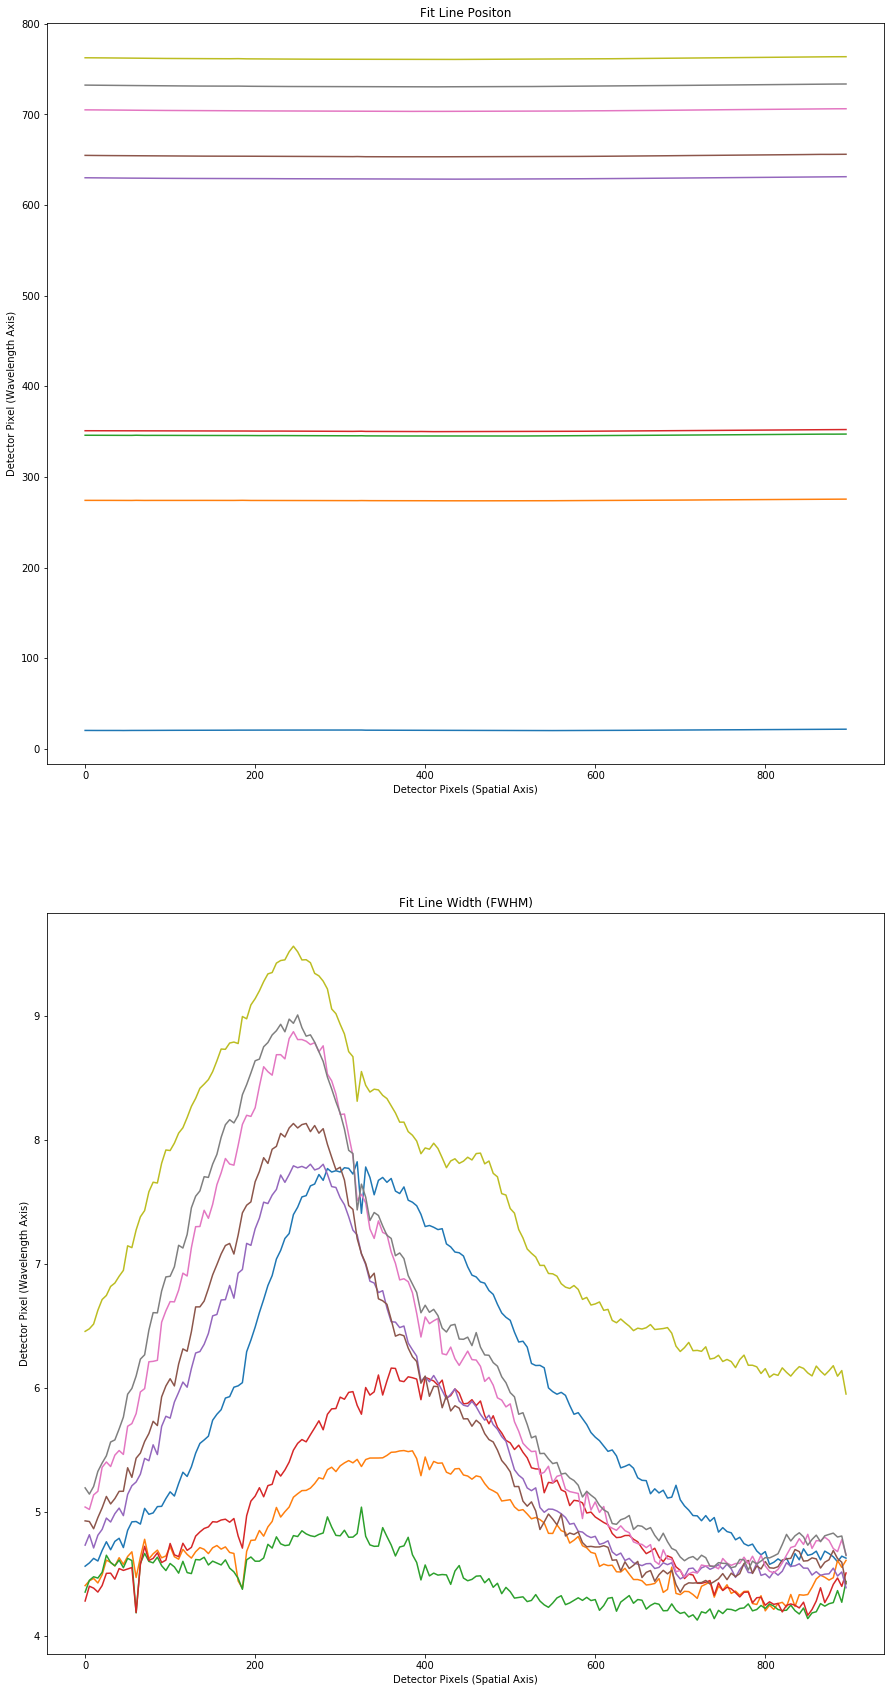

In [34]:
plt.figure(figsize=(15,30))
plt.subplot(211)
plt.plot(spatialaxis[range(0, arcimg.shape[0], spatial_col_skip)],pos)
plt.title('Fit Line Positon')
plt.xlabel('Detector Pixels (Spatial Axis)')
plt.ylabel('Detector Pixel (Wavelength Axis)')

plt.subplot(212)
plt.plot(spatialaxis[range(0, arcimg.shape[0], spatial_col_skip)],width*2.355)
plt.title('Fit Line Width (FWHM)')
plt.xlabel('Detector Pixels (Spatial Axis)')
plt.ylabel('Detector Pixel (Wavelength Axis)')

plt.show()